# Data Exploration

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visual settings
sns.set(style="whitegrid")
plt.style.use("ggplot")

In [9]:
# Load processed data
df = pd.read_csv("../data/processed/cleaned_fashion_sales.csv")
df.head()

,customer_reference_id,item_purchased,purchase_amount_(usd),date_purchase,review_rating,payment_method
0,4018,Handbag,4619.0,2023-02-05,3.2,Credit Card
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash


**Basic Summary**

In [10]:
# Dataset overview
print("Shape of the dataset:", df.shape)
df.info()

Shape of the dataset: (3400, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_reference_id  3400 non-null   int64  
 1   item_purchased         3400 non-null   object 
 2   purchase_amount_(usd)  3400 non-null   float64
 3   date_purchase          3400 non-null   object 
 4   review_rating          3400 non-null   float64
 5   payment_method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 159.5+ KB


**Target Variable Exploration**

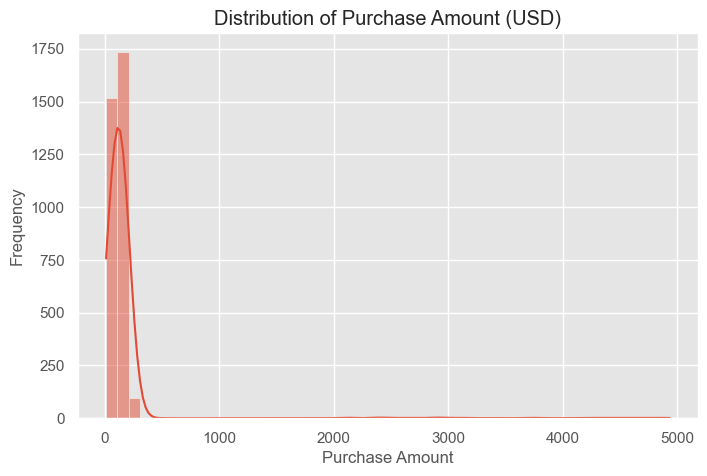

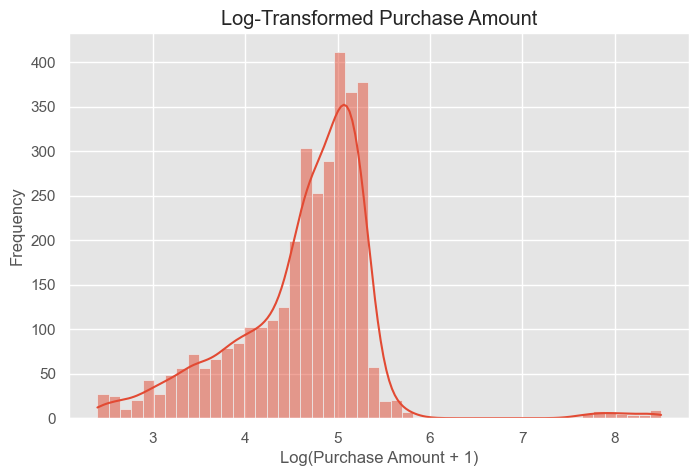

In [11]:
# Histogram of purchase amount
plt.figure(figsize=(8, 5))
sns.histplot(df['purchase_amount_(usd)'], bins=50, kde=True)
plt.title('Distribution of Purchase Amount (USD)')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

# Log-transformed histogram
df['log_purchase_amount'] = np.log1p(df['purchase_amount_(usd)'])

plt.figure(figsize=(8, 5))
sns.histplot(df['log_purchase_amount'], bins=50, kde=True)
plt.title('Log-Transformed Purchase Amount')
plt.xlabel('Log(Purchase Amount + 1)')
plt.ylabel('Frequency')
plt.show()

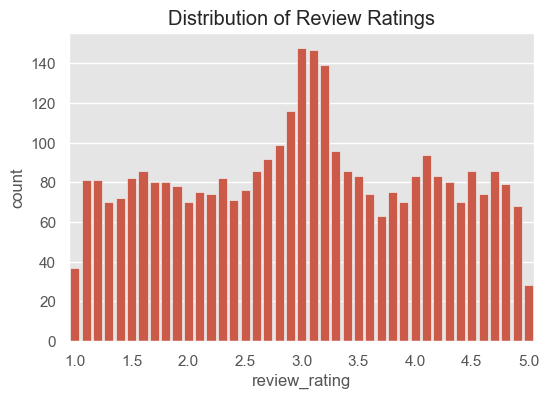

In [ ]:
# If using review_rating
if 'review_rating' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='review_rating', data=df)
    plt.title("Distribution of Review Ratings")
    plt.xticks(ticks=range(0, len(df['review_rating'].unique()), 5))  # Skip intervals
    plt.show()


**Categorical Feature Exploration**

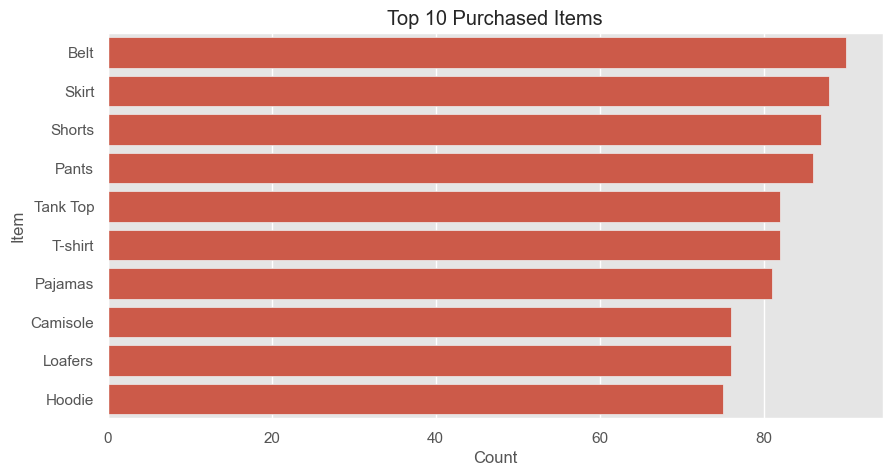

In [24]:
# Top 10 purchased items
plt.figure(figsize=(10, 5))
top_items = df['item_purchased'].value_counts().head(10)
sns.barplot(x=top_items.values, y=top_items.index)
plt.title("Top 10 Purchased Items")
plt.xlabel("Count")
plt.ylabel("Item")
plt.show()

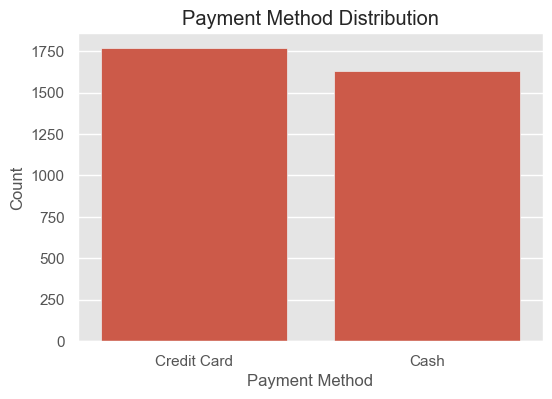

In [25]:
# Payment method distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='payment_method', data=df)
plt.title("Payment Method Distribution")
plt.xlabel("Payment Method")
plt.ylabel("Count")
plt.show()

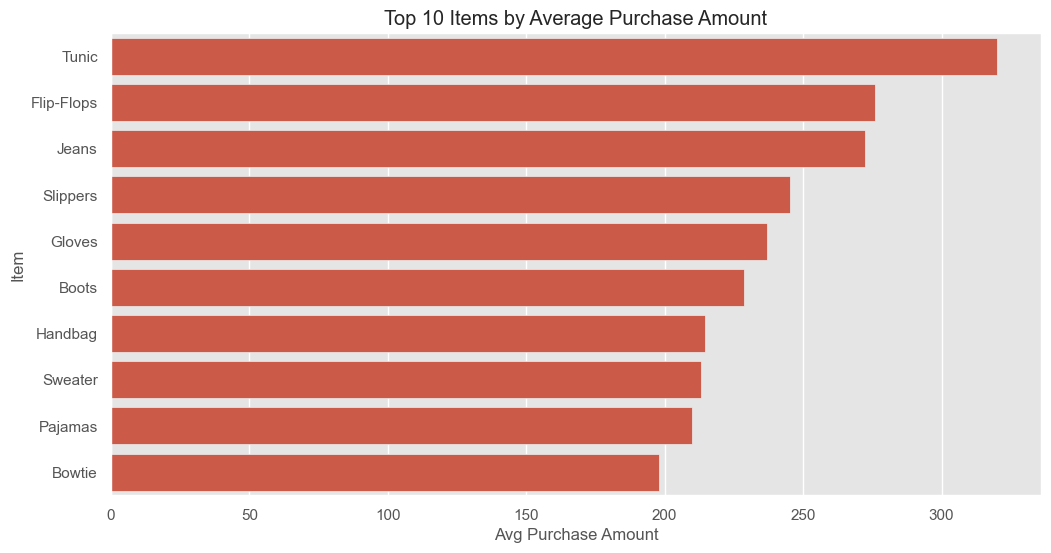

In [26]:
# Avg purchase amount by item
plt.figure(figsize=(12, 6))
avg_amount_by_item = df.groupby('item_purchased')['purchase_amount_(usd)'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=avg_amount_by_item.values, y=avg_amount_by_item.index)
plt.title("Top 10 Items by Average Purchase Amount")
plt.xlabel("Avg Purchase Amount")
plt.ylabel("Item")
plt.show()

**Temporal Trends**

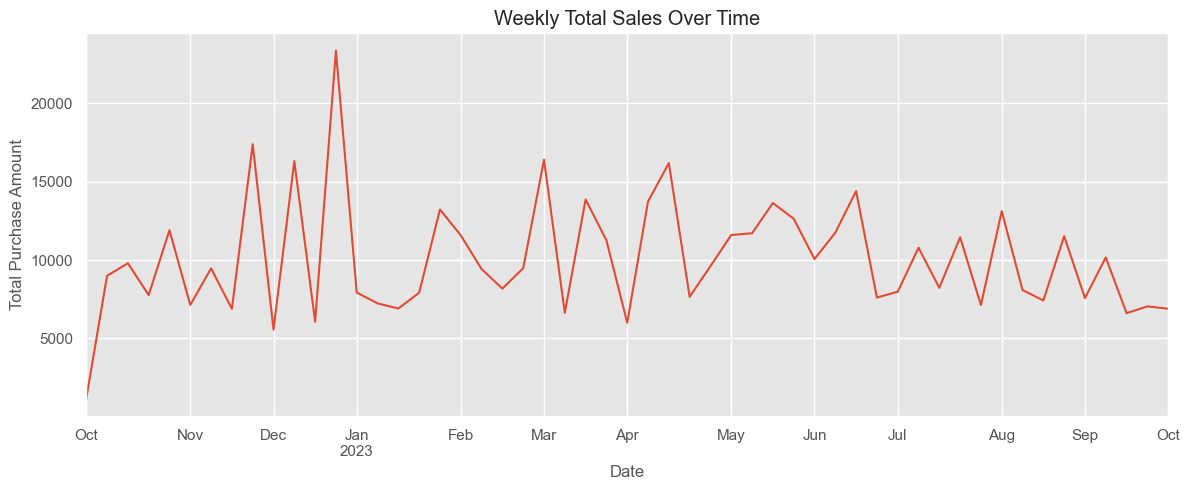

In [27]:
# Convert to datetime
df['date_purchase'] = pd.to_datetime(df['date_purchase'])

# Purchase trend over time
df.set_index('date_purchase')['purchase_amount_(usd)'].resample('W').sum().plot(figsize=(12, 5))
plt.title("Weekly Total Sales Over Time")
plt.ylabel("Total Purchase Amount")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

**Bivariate Exploration**

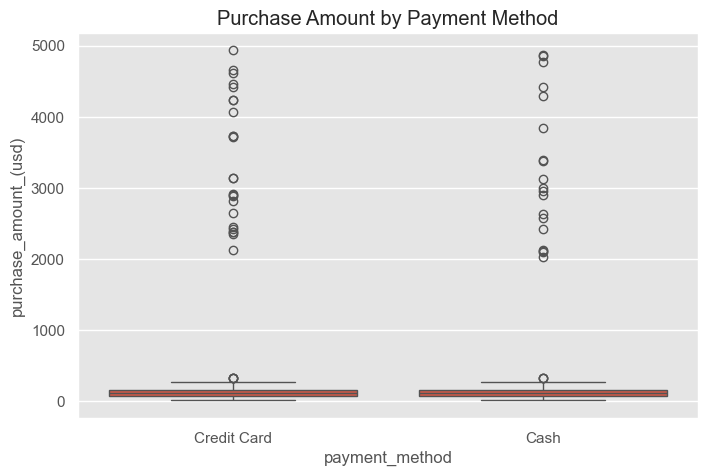

In [28]:
# Purchase amount by payment method
plt.figure(figsize=(8, 5))
sns.boxplot(x='payment_method', y='purchase_amount_(usd)', data=df)
plt.title("Purchase Amount by Payment Method")
plt.show()

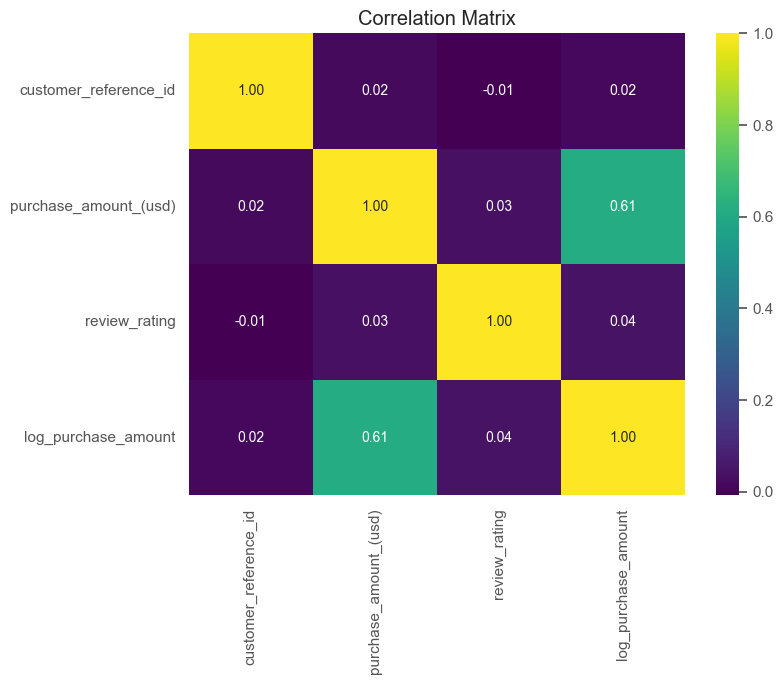

In [30]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()